###  $$The\ Time\ Series\ Analysis\ using\ ARIMA\ Model$$ 

### So, import some important libraries

In [1]:
import predict as pr;
import matplotlib.pyplot as plt;
import numpy as np;
import pandas as pd;
import statsmodels.api as sm;
import pmdarima as pm;
import time;
import warnings;
from tqdm import tqdm_notebook;
warnings.filterwarnings("ignore")

### Let's download the dataset using the module "predict". 
> Attention! You can to install all modules use the following command
**"pip install - r List_of_modules.txt"**

In [2]:
a=pr.Predict("EURUSD",market="OANDA", freg="4H",n_bars=150);

you are using nologin method, data you access may be limited


### Let's to do the pre analysis

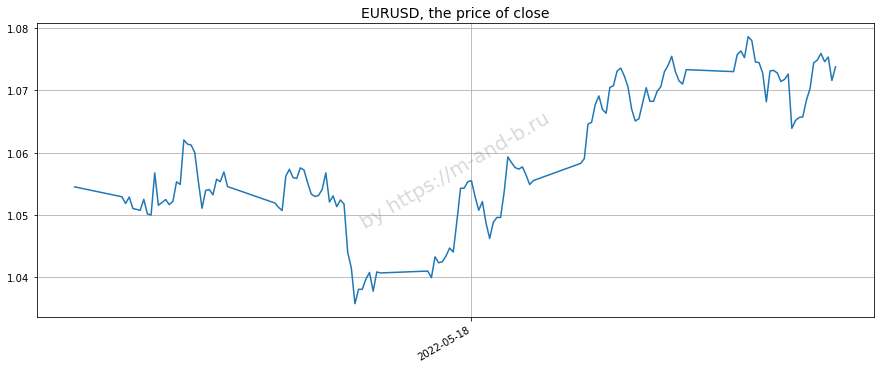

In [3]:
df=a.get_data();# get the data;
a.plot_data_close(w=15,h=6);# Look at the data

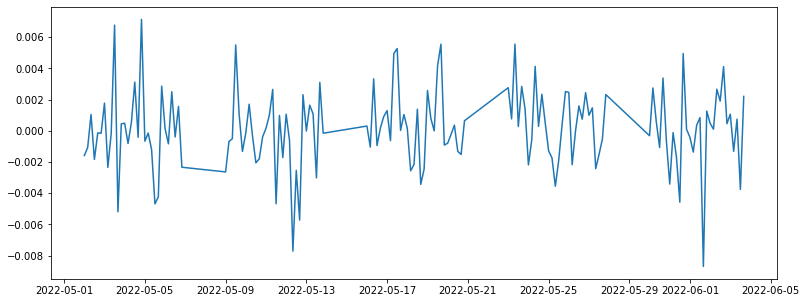

In [4]:
#Look at the diff data
x = df.close;
Dx=df['close'].diff()[1:];
plt.figure(figsize=(13,5));
plt.plot(Dx);
plt.show()



### To do the  DF-test on stationary of data

In [5]:
###########################################################
from statsmodels.tsa.stattools import adfuller
result = adfuller(x)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))
if result[1] >0.05:
    print("**********************************************")
    print("ADF TRUE, The TimeSeries is not stationary");
    print("**********************************************")
if result[1] <0.05:
    print("**********************************************");
    print("ADF FOLSE, The TimeSeries is stationary");
    print("**********************************************");
##########################################################

ADF Statistic: -1.115000
p-value: 0.709053
Critical Values:
	1%: -3.475
	5%: -2.881
	10%: -2.577
**********************************************
ADF TRUE, The TimeSeries is not stationary
**********************************************


### Start the process of modeling

In [6]:
TEST_SIZE = 10;

train, test = df['close'].iloc[:-TEST_SIZE], df['close'].iloc[-TEST_SIZE:];

x_train, x_test = np.array(range(train.shape[0])), np.array(range(train.shape[0], df['close'].shape[0]));

print(train.shape, x_train.shape, test.shape, x_test.shape);

(140,) (140,) (10,) (10,)


###  Do to analis the ARIMA(p,d,q) - model. 

> Details look for at the **"Osipov K.N. Stochastic Models in Acceptance Testing for Complex Machines / K.N. Osipov, E. Pervukchina, V. Golikova // 2016 Second International Symposium on Stochastic Models in Reliability Engineering, Life Science and Operations Management (SMRLO) 15-18 Feb. 2016 © 2016 IEEE, DOI 10.1109/SMRLO.2016.25, p.87 – 94."**

In [7]:
def Model(p,d,q, c="n",start=0):
    model = sm.tsa.arima.ARIMA(train,order=(p,d,q),trend=c)
    results = model.fit();
    prediction= results.get_forecast(TEST_SIZE);
    
    return results, prediction;

In [8]:
model_2 = pm.auto_arima(train, start_p=0, start_q=0,
                      test='adf',
                      max_p=10, max_q=10,
                      m=2,             
                      d=2,          
                      seasonal=False,   
                      start_P=0, 
                      D=None, 
                      trace=True,
                      error_action='trace',  
                      suppress_warnings=True, 
                      stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=-1157.770, Time=0.18 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=-1196.253, Time=0.21 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=-1229.259, Time=0.61 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=-1159.769, Time=0.12 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=-1223.241, Time=0.47 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=-1230.230, Time=0.50 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=-1227.123, Time=0.55 sec
 ARIMA(0,2,3)(0,0,0)[0] intercept   : AIC=-1234.122, Time=0.42 sec
 ARIMA(1,2,3)(0,0,0)[0] intercept   : AIC=-1230.636, Time=0.66 sec
 ARIMA(0,2,4)(0,0,0)[0] intercept   : AIC=-1215.754, Time=0.92 sec
 ARIMA(1,2,4)(0,0,0)[0] intercept   : AIC=-1212.910, Time=0.99 sec
 ARIMA(0,2,3)(0,0,0)[0]             : AIC=-1236.052, Time=0.31 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=-1232.210, Time=0.18 sec
 ARIMA(1,2,3)(0,0,0)[0]             : AIC=-1232.593, Time=0.38 sec
 ARIMA(0,2,4)(0,0,0

In [9]:
std=pd.DataFrame(model_2.predict(len(x_test),return_conf_int=True)[1][0:len(x_test)])
std.columns=["min","max"];

In [10]:
%%time
prediction1=Model(0,1,0,c="n");
prediction2=Model(model_2.get_params()["order"][0],model_2.get_params()["order"][1],model_2.get_params()["order"][2], c="n"); #Best model!!!
prediction3=Model(0,1,1);
prediction4=Model(3,0,20, c="c");

CPU times: total: 5.03 s
Wall time: 7.6 s


In [11]:
#model_2.summary()

In [12]:
prediction2[1].summary_frame(endog=0, alpha=0.05)[0:1]

close,mean,mean_se,mean_ci_lower,mean_ci_upper
140,1.064737,0.002578,1.059683,1.06979


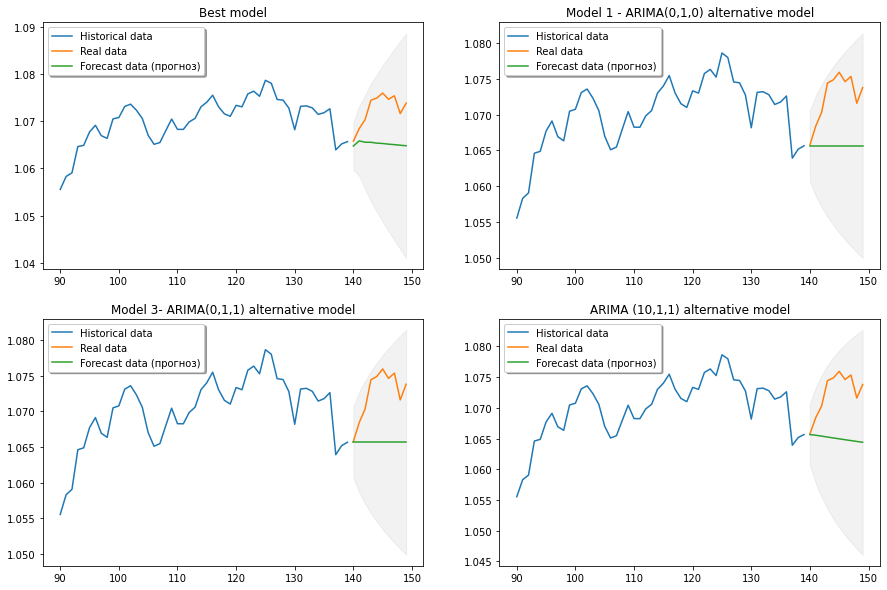

In [13]:
plt.figure(figsize=(15,10))
################################################################
plt.subplot(2,2,2)
plt.plot(x_train[len(x_train)-50:], train[len(x_train)-50:]);
plt.plot(x_test, test);
plt.plot(x_test,prediction1[1].predicted_mean);
plt.title("Model 1 - ARIMA(0,1,0) alternative model")
plt.legend(('Historical data', 'Real data', "Forecast data (прогноз)"), loc='upper left', shadow=True)
plt.fill_between(x_test,
                prediction1[1].summary_frame().mean_ci_lower,
                prediction1[1].summary_frame().mean_ci_upper,color='grey',alpha=.1)
#################################################################
plt.subplot(2,2,1);
plt.title("Best model")
plt.plot(x_train[len(x_train)-50:], train[len(x_train)-50:]);
plt.plot(x_test, test);
plt.plot(x_test,prediction2[1].predicted_mean);
#plt.plot(x_test,model_2.predict(len(x_test)));
plt.legend(('Historical data', 'Real data', "Forecast data (прогноз)"), loc='upper left', shadow=True)
plt.fill_between(x_test,
                prediction2[1].summary_frame().mean_ci_lower,
                prediction2[1].summary_frame().mean_ci_upper,color='grey',alpha=.1)
#################################################################
plt.subplot(2,2,3);
plt.title("Model 3- ARIMA(0,1,1) alternative model")
plt.plot(x_train[len(x_train)-50:], train[len(x_train)-50:]);
plt.plot(x_test, test);
plt.plot(x_test,prediction3[1].predicted_mean);
plt.legend(('Historical data', 'Real data', "Forecast data (прогноз)"), loc='upper left', shadow=True)
plt.fill_between(x_test,
                prediction3[1].summary_frame().mean_ci_lower,
                prediction3[1].summary_frame().mean_ci_upper,color='grey',alpha=.1)
#################################################################
plt.subplot(2,2,4);
plt.title("ARIMA (10,1,1) alternative model")
plt.plot(x_train[len(x_train)-50:], train[len(x_train)-50:]);
plt.plot(x_test, test);
plt.plot(x_test,prediction4[1].predicted_mean);
plt.legend(('Historical data', 'Real data', "Forecast data (прогноз)"), loc='upper left', shadow=True)
plt.fill_between(x_test,
                prediction4[1].summary_frame().mean_ci_lower,
                prediction4[1].summary_frame().mean_ci_upper,color='grey',alpha=.1)
plt.show()

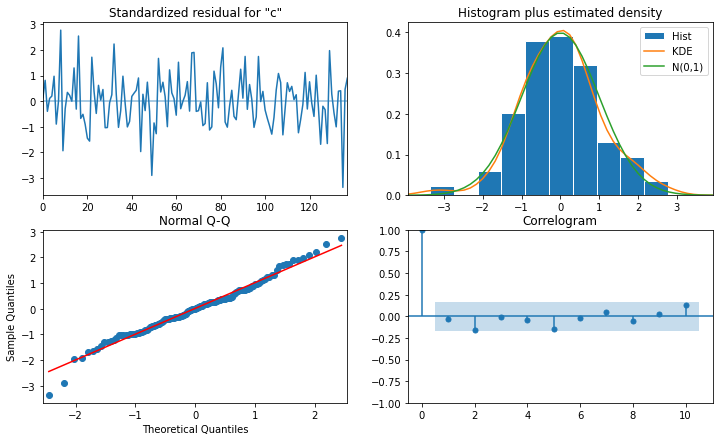

In [14]:
prediction2[0].plot_diagnostics(figsize=(12,7));

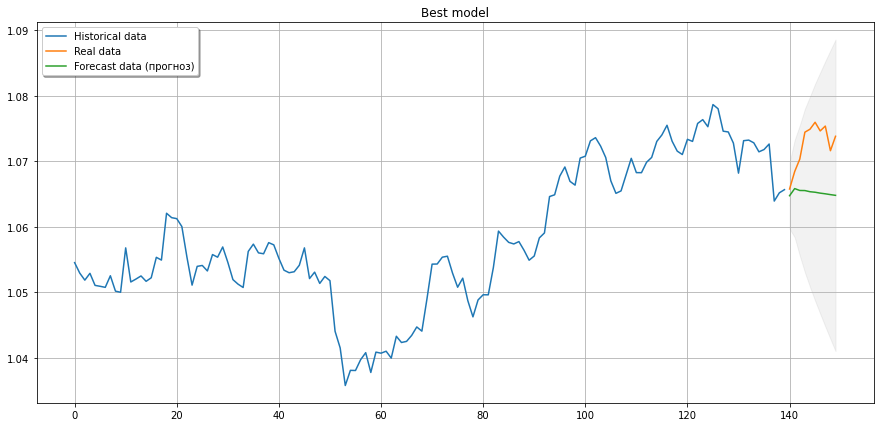

In [15]:
plt.figure(figsize=(15,7))
plt.title("Best model")
plt.plot(x_train, train);
plt.grid();
plt.plot(x_test, test);
#plt.plot(x_test,prediction2[1].predicted_mean);
plt.plot(x_test,model_2.predict(len(x_test),model_2.predict(len(x_test),return_conf_int=True)));
plt.legend(('Historical data', 'Real data', "Forecast data (прогноз)"), loc='upper left', shadow=True)
plt.fill_between(x_test,
                np.array(std["min"]),
                np.array(std["max"]),color='grey',alpha=.1)
plt.show()